In [16]:
import os
import numpy as np
import pandas as pd
import argparse
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
perf_csv_dir = "/cluster/tufts/hugheslab/prath01/results/mimic3/"
pchmm_perf_csv = glob.glob(os.path.join(perf_csv_dir,'**','semi_supervised_pchmm_performance.csv'), recursive=True)[0] 

In [32]:
pchmm_perf_csv

'/cluster/tufts/hugheslab/prath01/results/mimic3/semi_supervised_pchmm/classifier_per_tslice_performance/semi_supervised_pchmm_performance.csv'

In [57]:
perf_df = pd.read_csv(pchmm_perf_csv)
perc_labelled_list = perf_df['perc_labelled'].unique()
exclude_perc_labels = [5, 90]
perc_labelled_vals = [int(i) for i in perc_labelled_list if i not in exclude_perc_labels]
for i in exclude_perc_labels:
    drop_inds = perf_df['perc_labelled']==i
    perf_df = perf_df.loc[~drop_inds].reset_index(drop=True)
    
perc_labelled_vals

[10, 20, 30, 60]

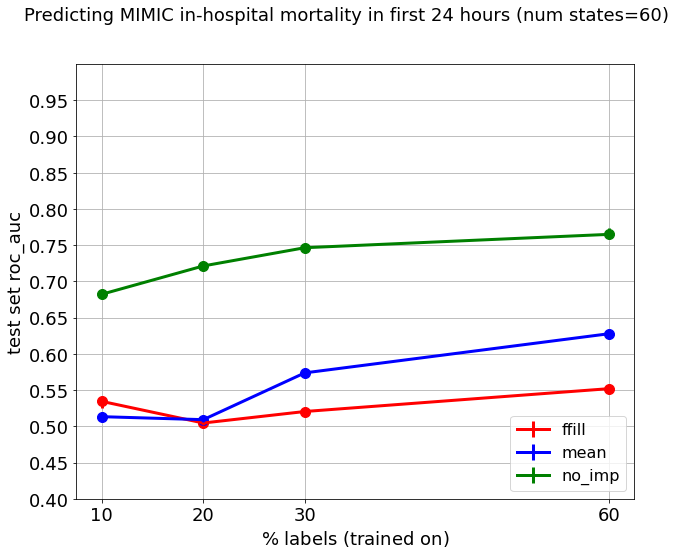

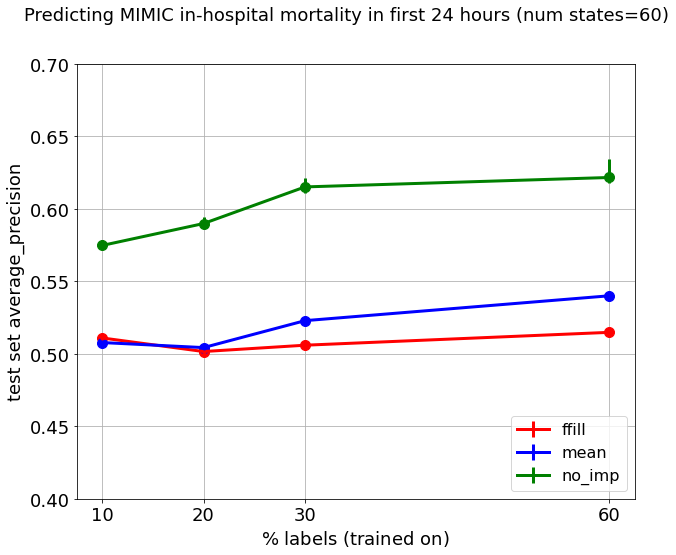

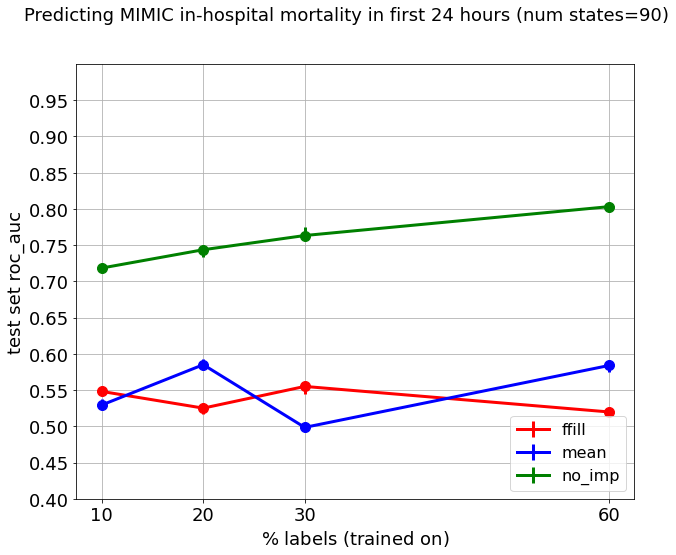

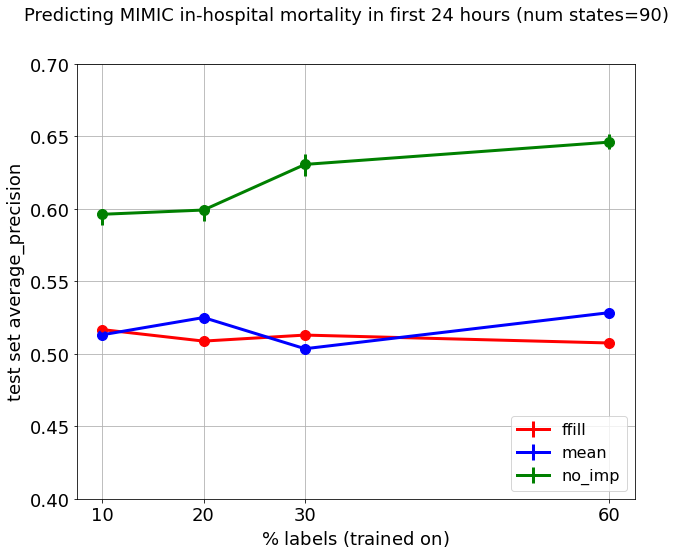

In [60]:
perf_measures = ['roc_auc', 'average_precision']
fontsize=18
suffix = 'first_24_hours'

yticks = np.arange(.1, 1, .05)
# states = 60

for states in [60, 90]:
    for perf_measure in perf_measures:
        f, axs = plt.subplots(figsize=[10,8])
        model_colors=['r', 'b', 'g', 'k', 'm', 'y', 'c', 'mediumseagreen']
        for p, imputation_strategy in enumerate(perf_df.imputation_strategy.unique()):
            inds = (perf_df.imputation_strategy==imputation_strategy)&(perf_df.n_states==states)
            cur_df = perf_df.loc[inds, :].copy()
            y = cur_df.loc[cur_df.percentile==50, perf_measure].values
            y_err  = np.zeros((2, len(perc_labelled_vals)))
            try:
                y_err[0,:] = y - cur_df.loc[cur_df.percentile==5, perf_measure].values
            except:
                print('Error in %s'%imputation_strategy)
    #             from IPython import embed; embed()
            y_err[1,:] = cur_df.loc[cur_df.percentile==95, perf_measure].values - y

            axs.errorbar(x=perc_labelled_vals, y=y, yerr=y_err, label=imputation_strategy, fmt='.-', linewidth=3, color=model_colors[p])
            axs.plot(perc_labelled_vals, y, '.', markersize=20, color=model_colors[p])

        axs.set_xlabel(r'$\%$ labels (trained on)', fontsize=fontsize)
        fig_aka='perf_%s_semi_supervised_%s.pdf'%(perf_measure, suffix)
        axs.set_xticks(perc_labelled_vals)
        axs.set_xticklabels([str(i) for i in perc_labelled_vals])
        axs.set_yticks(yticks)
        axs.set_yticklabels(['%.2f'%i for i in yticks])

        if perf_measure == 'roc_auc':
            axs.set_ylim([0.4, 1])
        elif perf_measure == 'average_precision':
            axs.set_ylim([0.4, 0.7])

        axs.set_ylabel('test set %s'%perf_measure, fontsize=fontsize)
        axs.legend(fontsize=fontsize-2, loc='lower right')
        axs.tick_params(labelsize=fontsize)
    #     fig_name = os.path.join(args.output_dir, fig_aka)
        plt.suptitle('Predicting MIMIC in-hospital mortality in first 24 hours (num states=%s)'%str(states),
                     fontsize=fontsize)
        plt.grid(True)
        plt.show()
#         f.savefig("mimic_ssl_in_hosp_%s")
#     print('Saved results to %s'%fig_name)

In [12]:
inds = (perf_df.imputation_strategy=="ffill")
perf_df[inds]

,average_precision,balanced_accuracy,imputation_strategy,log_loss,model,n_states,perc_labelled,percentile,precision,recall,roc_auc
0,0.491630,0.500000,ffill,0.456437,PCHMM-n_states=5,5,5,5.0,0.000000,0.000000,0.458662
1,0.492083,0.500000,ffill,0.469807,PCHMM-n_states=5,5,5,50.0,0.000000,0.000000,0.459079
2,0.493360,0.500000,ffill,0.473858,PCHMM-n_states=5,5,5,95.0,0.000000,0.000000,0.464368
9,0.487504,0.500000,ffill,0.477720,PCHMM-n_states=10,10,5,5.0,0.000000,0.000000,0.444369
10,0.489577,0.500000,ffill,0.491192,PCHMM-n_states=10,10,5,50.0,0.000000,0.000000,0.450063
...,...,...,...,...,...,...,...,...,...,...,...
253,0.522657,0.503816,ffill,0.482679,PCHMM-n_states=60,60,90,50.0,0.260870,0.010730,0.578102
254,0.524259,0.505105,ffill,0.484427,PCHMM-n_states=60,60,90,95.0,0.308187,0.013482,0.584192
261,0.518921,0.500165,ffill,0.463827,PCHMM-n_states=90,90,90,5.0,0.113889,0.002135,0.560820
262,0.520658,0.500358,ffill,0.474393,PCHMM-n_states=90,90,90,50.0,0.142857,0.002160,0.564884
